# Anomaly detection experiment

In [7]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from itertools import repeat, chain
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
# from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm
from lightgbm import LGBMRegressor
import shap
import scipy.sparse

style.use('seaborn-v0_8-ticks')
plt.rcParams.update({'figure.facecolor':'white'})
sns.set_theme(style="ticks")

import os
from pathlib import Path

# Store the original directory path in a global variable if it doesn't exist yet
if not hasattr(__builtins__, '_original_dir'):
    __builtins__._original_dir = os.getcwd()
    root_dir = Path(__builtins__._original_dir).resolve().parent
    os.chdir(root_dir)
    print(f"Changed working directory to: {os.getcwd()}")
else:
    print(f"Directory already changed. Current working directory: {os.getcwd()}")

from utils.data_preparation import preprocess_data, split_data, mapping
from processing.custom_metrics import nash_sutcliffe, kling_gupta

Directory already changed. Current working directory: C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam


In [8]:
color = '\033[1m\033[38;5;208m' 
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version SHAP: {shap.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
print(f"{color}Version seasborn: {sns.__version__}")

Version scikit-learn: 1.5.2
Version lightgbm: 4.5.0
Version SHAP: 0.46.0
Version pandas: 2.2.3
Version numpy: 1.26.4
Version seasborn: 0.13.2


### **Define target/model of analysis**

In [9]:
model_name = 'LightGBM'

In [10]:
target = 'MB18_ANOMALY'

In [11]:
features = ['GV1', 'GV3', 'GV51', 'h_ANOMALY', 'MB4_ANOMALY', 'MB8_ANOMALY', 'MB10_ANOMALY', 'MB18_ANOMALY']

In [12]:
test_size = 0.2
poly_degree = 0

if target in features: features.remove(target)
path = f'./data/LOS_DAMM_{mapping(target)}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])

# Extract start and end dates
dates = data['Date-Time']
start_date = dates.iloc[0].date()  # First date (YYYY-MM-DD)
end_date = dates.iloc[-1].date()  # Last date (YYYY-MM-DD)

# Preprocess the data (You would need to define preprocess_data elsewhere in your code)
X, y, dates = preprocess_data(features, target, start_date, end_date, poly_degree=poly_degree, test_size=test_size)

# Split the data into training and testing sets (Assumes split_data is defined elsewhere)
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)

print("data loaded")

with open(f'./visualization/models/{model_name}/{model_name}_model_{target}.pkl', 'rb') as f:
    model = pickle.load(f)

print(f"{target} {model_name} loaded")

data loaded
MB18_ANOMALY LightGBM loaded


In [13]:
print(X)

          t     GV1       GV3     GV51  h_ANOMALY  MB4_ANOMALY  MB8_ANOMALY  \
0         1  558.26  557.4900  555.180     568.93        2.065       0.2312   
1         1  558.26  557.4900  555.180     568.93        2.065       0.2480   
2         1  558.26  557.4900  555.180     568.93        2.065       0.2068   
3         1  558.26  557.4900  555.180     568.94        2.065       0.2068   
4         1  558.26  557.4900  555.180     568.94        2.065       0.2068   
...     ...     ...       ...      ...        ...          ...          ...   
40148  1673  550.81  550.9708  548.823     557.59        2.111       0.0000   
40149  1673  550.81  550.9708  548.823     557.59        2.111       0.0000   
40150  1673  550.81  550.9708  548.823     557.59        2.111       0.0000   
40151  1673  550.81  550.9528  548.808     557.59        2.111       0.0000   
40152  1674  550.81  550.9528  548.808     557.60        2.111       0.0000   

       MB10_ANOMALY  
0             3.464  
1      

In [14]:
print(y)

0         8.200
1         8.200
2         8.200
3         8.200
4         8.200
          ...  
40148    10.674
40149    10.674
40150    10.674
40151    10.674
40152    10.359
Name: MB18_A_D_ANOMALY, Length: 40153, dtype: float64


## Visualize anomaly scenario data

<Figure size 640x480 with 0 Axes>

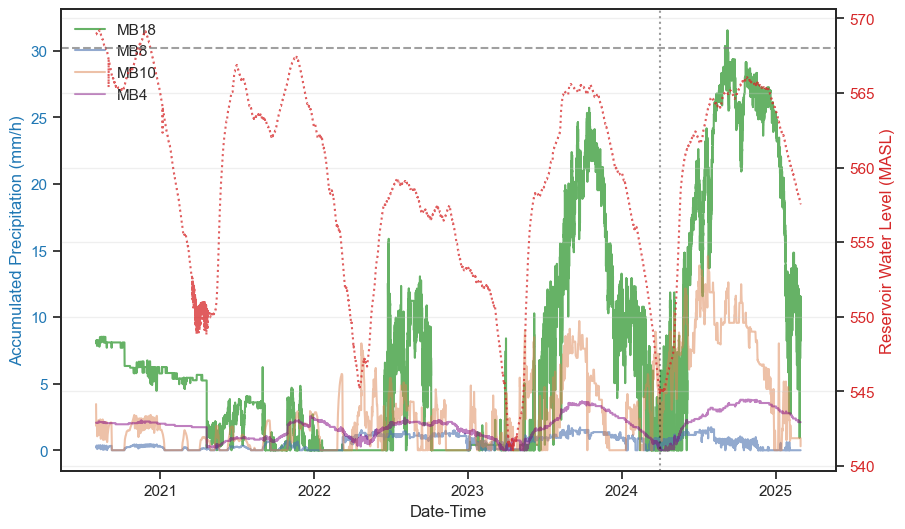

In [16]:
# Precipitation vs water level data
plt.clf()
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(dates, y, label='MB18', alpha=.6, color='green')
ax1.plot(dates, X['MB8_ANOMALY'], label='MB8', alpha=.6)
ax1.plot(dates, X['MB10_ANOMALY'], label='MB10', alpha=.5)
ax1.plot(dates, X['MB4_ANOMALY'], label='MB4', alpha=.5, color='purple')


ax1.axvline(x=dates.iloc[split_index], color='black', alpha=.4, linestyle=':')

ax1.set_xlabel('Date-Time')
ax1.set_ylabel('Accumulated Precipitation (mm/h)', color='tab:blue')
# Add legends for both axes
plt.legend(loc='best')

ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(dates, X['h_ANOMALY'], label='h', alpha=.75, color='tab:red', linestyle=':')

ax2.axhline(y=568, label='DG', alpha=.75, color='gray', linestyle='--')
ax2.set_ylabel('Reservoir Water Level (MASL)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set common x-axis labels and rotation
plt.xticks(rotation=45)


# Enable grid
plt.grid(True, alpha=0.3)

# Show plot
plt.show()

In [17]:
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.13099828299115218,
              learning_rate=0.010503425358747043, linear_tree=False,
              max_depth=6, min_child_samples=522,
              min_split_gain=0.7447944827820447, n_estimators=2630,
              num_leaves=21, reg_alpha=3.264662234133224e-07,
              reg_lambda=0.0016466758886136525, subsample=0.23526471816884406,
              verbose=-1)

In [18]:
print("Feature names:")
print(X.columns, '\n')

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
all_predictions = model.predict(X)

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mae_test = mean_absolute_error(y_test, test_predictions)
NSE_test = nash_sutcliffe(y_test, test_predictions)
KGE_test = kling_gupta(y_test, test_predictions)

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)
print("NSE Test:", NSE_test)
print("KGE Test:", KGE_test)

Feature names:
Index(['t', 'GV1', 'GV3', 'GV51', 'h_ANOMALY', 'MB4_ANOMALY', 'MB8_ANOMALY',
       'MB10_ANOMALY'],
      dtype='object') 

RMSE Train: 0.9340659488201618
RMSE Test: 10.684042146125144
MAE Test: 9.476701152091266
NSE Test: -0.323810965418468
KGE Test: 0.07265990919435583


<Figure size 640x480 with 0 Axes>

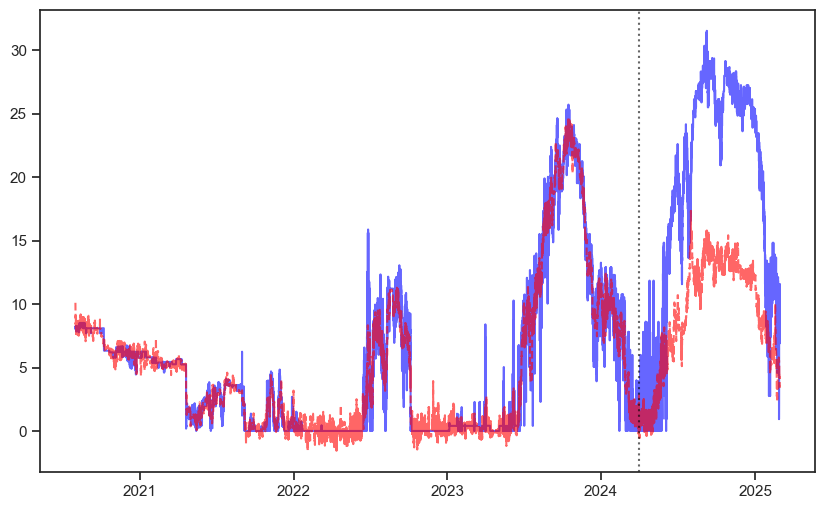

In [19]:

plt.clf()
plt.figure(figsize=(10, 6))


plt.plot(dates, y, label='true', alpha=.6, color='blue')
plt.plot(dates, all_predictions, label='pred', alpha=.6, color='red', linestyle='--')

plt.axvline(x=dates.iloc[split_index], color='black', alpha=.6, linestyle=':')